# Meridional Heat Transport

This notebook calculates the model's meridional heat transport (MHT) using two methods based on distinct MOM5 diagnostics. The methods and the caveats associated with them are listed below:

1. `temp_yflux_adv_int_z` (depth-integrated meridional heat transport due to resolved advection): This diagnostic is computed online and is therefore accurate. However, being an estimate of the advective meridional heat transport, it doesn't contain any heat transport due to diffusive parameterisations in the model.

2. `net_sfc_heating` (net surface heat flux): This method estimates the meridional heat transport and is approximate because of the steady state assumption. Ideally, frazil formation at higher latitudes should be added to the net surface heating variable, but we skip it here as the diagnostic is not available with this experiment.
  
Currently, this notebook calculates the total (all basins) MHT, and it also includes comparisons to a few observational products. Basin-specific MHT can be calculated by defining relevant masks; see the [equivalent recipe](https://cosima-recipes.readthedocs.io/en/latest/Examples/Atlantic_IndoPacific_Basin_Overturning_Circulation.html).

## Loading relevant libraries

In [1]:
import numpy as np
import xarray as xr
import cf_xarray as cfxr
# to be able to read unit attributes following the CF conventions
import cf_xarray.units # must be imported before pint_xarray
import pint_xarray
from pint_xarray import unit_registry as ureg

import matplotlib.pyplot as plt

from os import environ
environ["PYTHONWARNINGS"] = "ignore"

Start dask cluster.

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40173,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35387,Total threads: 1
Dashboard: /proxy/37445/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:40577,


## Loading model data

Load ACCESS-NRI default catalog

In [3]:
import intake
catalog = intake.cat.access_nri

Define experiment of interest

In [4]:
experiment = '025deg_jra55_iaf_omip2_cycle2'

We are now ready to query the database and load the data to start our analysis. We load `temp_yflux_adv_int_z`. For this example, we have chosen to use 6 years of output.

## Method 1: using depth-integrated meridional heat transport due to resolved advection

In [5]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='temp_yflux_adv_int_z')
darray = var_search.to_dask(xarray_open_kwargs={
            "decode_timedelta": False,
            'chunks': "auto"
        })
darray = darray['temp_yflux_adv_int_z']

Viewing the variable containing our data provides a number of key information, including:

- *Shape of dataset* - In this case the data includes 72 time steps, 1080 steps along the y axis and 1440 along the x axis.
- *Name of coordinates* - Our data includes `time`, `yu_ocean` (i.e., latitude), and `xt_ocean` (i.e., longitude).
- *Values included under each coordinate* - We can see that `time` includes monthly values from 2198-01-14 to 2203-12-14.
- *Metadata* - This information is included under `Attributes` and it includes things like units.

## Calculating mean and converting units
We can see that our dataset is in Watts (W), so we convert to petawatts (PW).

In [6]:
darray.attrs['units'] = "watt"
darray = darray.pint.quantify()
darray = darray.pint.to(units="petawatt")

and then we compute the mean across `time` and sum over all longitudes.

In [7]:
mht_method1 = darray.mean('time').cf.sum('longitude')
mht_method1 = mht_method1.pint.dequantify()

## Method 2: using the net surface heat flux (assuming steady state)

First, we load the surface heat flux and grid metrics:

In [43]:
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable='net_sfc_heating')
darray = var_search.to_dask(xarray_open_kwargs={
            "decode_timedelta": False,
            'chunks': "auto"
        })
shflux = darray['net_sfc_heating']

In [44]:
shflux.attrs["units"] = "watt/m2"
shflux = shflux.pint.quantify()

Take the time mean.

In [49]:
shflux_am = shflux.pint.dequantify().mean('time').load()

In [50]:
shflux_am = shflux_am.pint.quantify(units=shflux.pint.units)

In [51]:
first_ocean_grid = next((p for p in cat_subset.df.path if p.endswith("ocean_grid.nc")), None)

In [52]:
first_ocean_grid

'/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle2/output061/ocean/ocean_grid.nc'

In [53]:
ocean_grid = cat_subset.search(path=first_ocean_grid)
area = ocean_grid.to_dask()['area_t'].pint.quantify()
lat = ocean_grid.to_dask()['geolat_t'].pint.quantify()
latv = ocean_grid.to_dask()['yt_ocean'].pint.quantify()

Now calculate Meridional Heat Flux (MHF):

$$\textrm{MHF} = \textrm{Cumulative sum of } (\textrm{SHFLUX} \times \textrm{AREA}) \textrm{ along latitudes}$$

In [54]:
# create left edge for bottom bin
latv_bins = np.hstack(([-90], latv.values))

mhf = shflux_am * area
mhf = mhf.pint.dequantify()
mhf = mhf.groupby_bins("geolat_t", latv_bins)
mhf = mhf.sum()
mhf = mhf.cumsum()
mhf = mhf.rename(geolat_t_bins="yt_ocean")

mhf.coords["yt_ocean"] = latv

mhf.attrs['units'] = (shflux_am * area).pint.units
mhf = mhf.pint.quantify()

mht_method2 = mhf + (mhf.isel(yt_ocean=0) - mhf.isel(yt_ocean=-1)) / 2
mht_method2

<xarray.DataArray (yt_ocean: 1080)> Size: 4kB
<Quantity(dask.array<add, shape=(1080,), dtype=float32, chunksize=(1080,), chunktype=numpy.ndarray>, 'watt')>
Coordinates:
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95

In [55]:
mht_method2 = mht_method2.pint.to('petawatt') # convert to PetaWatt
mht_method2 = mht_method2.pint.dequantify()

## Comparison between model output and observations
Before producing our figure, we compare the model output with observations to check the model accuracy. These observations are derived using various methods, in particular using surface flux observations and method 2 (which assumes a steady state).

### Read ERBE Period Ocean and Atmospheric Heat Transport
Observations are also available on `gadi`, here we show how to load them to our notebook.

In [56]:
#Path to the file containing observations
filename = '/g/data3/ik11/from_hh5_tmp/cosima/observations/original/MHT/obs_vq_am_estimates.txt'

#Creating empty variables to store our observations
erbe_mht = []
erbe_lat = []

#Opening data and saving it to empty variables above
with open(filename) as f:
    #Open each line from rows 1 to 96
    for line in f.readlines()[1:96]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting latitude and MHT and saving to empty variables
        erbe_lat.append(float(sline[0]))
        erbe_mht.append(float(sline[3]))

#Checking MHT variables
erbe_mht

[7.82256e-05,
 -0.00548183,
 -0.00534277,
 -0.00778958,
 -0.0153764,
 -0.0189109,
 -0.0172473,
 -0.0321044,
 -0.0647783,
 -0.104008,
 -0.129806,
 -0.202605,
 -0.297446,
 -0.374377,
 -0.424618,
 -0.464923,
 -0.508466,
 -0.544651,
 -0.56517,
 -0.575634,
 -0.563567,
 -0.51931,
 -0.45106,
 -0.377069,
 -0.310393,
 -0.271679,
 -0.279999,
 -0.329881,
 -0.39744,
 -0.464742,
 -0.515384,
 -0.565431,
 -0.620221,
 -0.678495,
 -0.736833,
 -0.790937,
 -0.843637,
 -0.90752,
 -0.984516,
 -1.05272,
 -1.0956,
 -1.10212,
 -1.05218,
 -0.93882,
 -0.761357,
 -0.502307,
 -0.155427,
 0.253559,
 0.666604,
 1.00846,
 1.25254,
 1.42962,
 1.57235,
 1.69269,
 1.78862,
 1.84355,
 1.85095,
 1.82898,
 1.79722,
 1.76105,
 1.71365,
 1.65596,
 1.59826,
 1.53441,
 1.45553,
 1.34517,
 1.20096,
 1.03473,
 0.856831,
 0.704894,
 0.62273,
 0.602973,
 0.60382,
 0.602437,
 0.599438,
 0.588678,
 0.573292,
 0.5557,
 0.518399,
 0.46073,
 0.40554,
 0.361088,
 0.328643,
 0.303888,
 0.271855,
 0.232879,
 0.18562,
 0.146825,
 0.110927

### Read NCEP and ECMWF Oceanic and Atmospheric Transport Products

These datasets are available at https://climatedataguide.ucar.edu/climate-data. We use a climatological mean of surface fluxes or vertically integrated total energy divergence for oceanic and atmospheric transports respectively for the period between February 1985 - April 1989.

In [57]:
#Path to the file containing observations
filename = '/g/data/tm70/rb5533/ANNUAL_TRANSPORTS_1985_1989.ascii'

#Creating empty variables to store our observations
ncep_g_mht = []
ecwmf_g_mht = []
ncep_g_err = []
ecwmf_g_err = []
ncep_a_mht = []
ecwmf_a_mht = []
ncep_a_err = []
ecwmf_a_err = []
ncep_p_mht = []
ecwmf_p_mht = []
ncep_p_err = []
ecwmf_p_err = []
ncep_i_mht = []
ecwmf_i_mht = []
ncep_i_err = []
ecwmf_i_err = []
ncep_ip_mht = []
ecwmf_ip_mht = []
ncep_ip_err = []
ecwmf_ip_err = []
o_lat = []

#Opening data and saving it to empty variables above
with open(filename) as f:
#Open each line in file (ignoring the first row)
    for line in f.readlines()[1:]:
        #Separating each line to extract data
        line = line.strip()
        sline = line.split()
        #Extracting values and saving to correct variable defined above
        o_lat.append(float(sline[0]) * 0.01)         # T42 latitudes (north to south)
        ncep_g_mht.append(float(sline[4]) * 0.01)    # Residual Ocean Transport - NCEP
        ecwmf_g_mht.append(float(sline[5]) * 0.01)   # Residual Ocean Transport - ECWMF
        ncep_a_mht.append(float(sline[7]) * 0.01)    # Atlantic Ocean Basin Transport - NCEP
        ncep_p_mht.append(float(sline[8]) * 0.01)    # Pacific Ocean Basin Transport - NCEP
        ncep_i_mht.append(float(sline[9]) * 0.01)    # Indian Ocean Basin Transport - NCEP
        ncep_g_err.append(float(sline[10]) * 0.01)   # Error Bars for NCEP Total Transports
        ncep_a_err.append(float(sline[11]) * 0.01)   # Error Bars for NCEP Atlantic Transports 
        ncep_p_err.append(float(sline[12]) * 0.01)   # Error Bars for NCEP Pacific Transports 
        ncep_i_err.append(float(sline[13]) * 0.01)   # Error Bars for NCEP Indian Transports 
        ecwmf_a_mht.append(float(sline[15]) * 0.01)  # Atlantic Ocean Basin Transport - ECWMF
        ecwmf_p_mht.append(float(sline[16]) * 0.01)  # Pacific Ocean Basin Transport - ECWMF
        ecwmf_i_mht.append(float(sline[17]) * 0.01)  # Indian Ocean Basin Transport - ECWMF
        ecwmf_g_err.append(float(sline[18]) * 0.01)  # Error Bars for ECWMF Total Transports
        ecwmf_a_err.append(float(sline[19]) * 0.01)  # Error Bars for NCEP Atlantic Transports
        ecwmf_p_err.append(float(sline[20]) * 0.01)  # Error Bars for NCEP Pacific Transports
        ecwmf_i_err.append(float(sline[21]) * 0.01)  # Error Bars for NCEP Indian Transports

#Calculating MHT
ncep_ip_mht  = [a+b for a, b in zip(ncep_p_mht,ncep_i_mht)]
ecwmf_ip_mht = [a+b for a, b in zip(ecwmf_p_mht,ecwmf_i_mht)]
ncep_ip_err  = [max(a, b) for a, b in zip(ncep_p_err, ncep_i_err)]
ecwmf_ip_err = [max(a, b) for a, b in zip(ecwmf_p_err, ecwmf_i_err)]

## Plotting model outputs against observations

We plot the global meridional heat transport as calculated from model outputs (blue line) and observations.

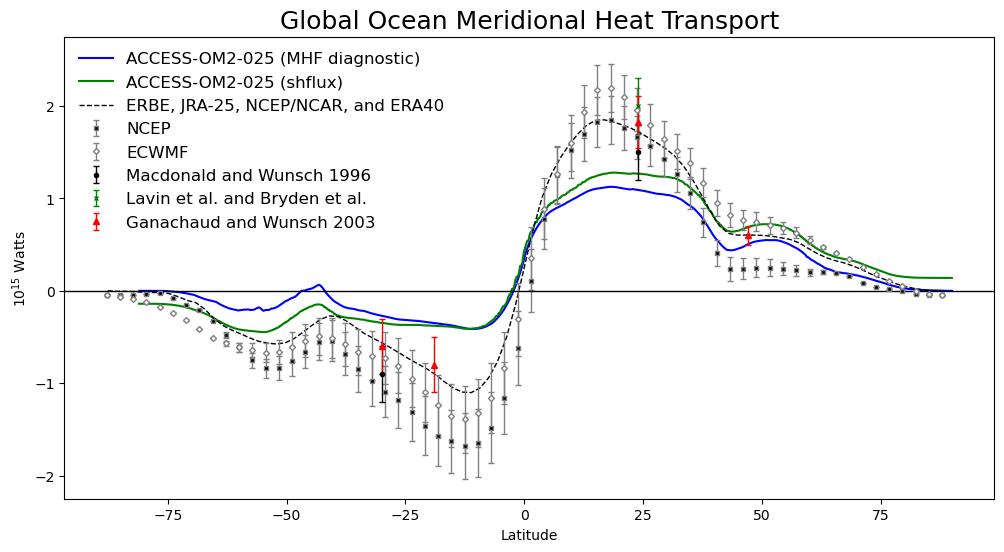

In [58]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)

#Plotting MHT from model outputs
mht_method1.plot(ax = ax, color = "blue", label = "ACCESS-OM2-025 (MHF diagnostic)")
mht_method2.plot(ax = ax, color = "green", label = "ACCESS-OM2-025 (shflux)")

#Adding observations and error bars for observations
ax.plot(erbe_lat, erbe_mht, 'k--', linewidth=1, label="ERBE, JRA-25, NCEP/NCAR, and ERA40")
plt.errorbar(o_lat[::-1], ncep_g_mht[::-1], yerr=ncep_g_err[::-1], c='gray', fmt='s', 
             markerfacecolor='k', markersize=3, capsize=2, linewidth=1, label="NCEP")
plt.errorbar(o_lat[::-1], ecwmf_g_mht[::-1], yerr=ecwmf_g_err[::-1], c='gray', fmt='D', 
             markerfacecolor='white', markersize=3, capsize=2, linewidth=1, label="ECWMF")
plt.errorbar( 24,  1.5,  yerr=0.3,  fmt='o', c='black', markersize=3, capsize=2, linewidth=1,
             label="Macdonald and Wunsch 1996")
plt.errorbar(-30, -0.9,  yerr=0.3,  fmt='o', c='black', markersize=3, capsize=2, linewidth=1)
plt.errorbar( 24,  2.0,  yerr=0.3,  fmt='x', c='green', markersize=3, capsize=2, linewidth=1,
             label="Lavin et al. and Bryden et al.")
plt.errorbar( 24,  1.83, yerr=0.28, fmt='^', c='red',   markersize=4, capsize=2, linewidth=1,
             label="Ganachaud and Wunsch 2003")
plt.errorbar(-30, -0.6,  yerr=0.3,  fmt='^', c='red',   markersize=4, capsize=2, linewidth=1)
plt.errorbar(-19, -0.8,  yerr=0.3,  fmt='^', c='red',   markersize=4, capsize=2, linewidth=1)
plt.errorbar( 47,  0.6,  yerr=0.1,  fmt='^', c='red',   markersize=4, capsize=2, linewidth=1)

# add legend
plt.legend(frameon=False, fontsize=12)
plt.axhline(y=0, linewidth=1, color='black')

# limits along the y axis
plt.ylim(-2.25, 2.75)

# add titles and labels
plt.title('Global Ocean Meridional Heat Transport', fontsize=18)
plt.xlabel('Latitude')
plt.ylabel('$10^{15}$ Watts');